# Assignment 2: Regression GD w+w/o regularization

> Joshua Shell, Nathaniel Hernandez, Nicholas Malott

We continue with the insurance data set, this time we will consider all attributes except the region attribute, for which the following gradient descent algorithms are to be applied:

* **Batch**: without L2 regularization, with L2 regularization, with L1 regularization
* **Stochastic**: without L2 regularization, with L2 regularization, with L1 regularization
* **Mini Batch**: without L2 regularization, with L2 regularization, with L1 regularization

The code is organized as follows:

1.   Imports and Functions
2.   Dataset Inspection
3.   Gradient Descent Function, Plotting, Cross-validation
4.   Batch Gradient Descent
5.   Stochastic Gradient Descent
6.   Mini Batch Gradient Descent




# 1. Import and Functions


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd 
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 2. Dataset Inspection

Inspect / analyze the data set before you start the ML portion: Plot the data before proceeding, normalize the data as follows: if X is the data set (i.e., without the output y) standardize it by subtracting from each column its mean and dividing it by the standard deviation.  **Do this, before you extend the data set by adding the extra column of 1s.**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

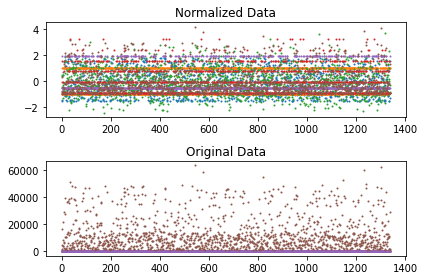

In [ ]:
#@title
#Read our data
dataset = pd.read_csv('/content/insurance-1.csv')

#Drop column 'region'
dataset = dataset.drop(['region'], axis=1)

#Update sex, smoker to be categorical (binary)
dataset.sex = dataset.sex.map({'male':0,'female':1})
dataset.smoker = dataset.smoker.map({'no':0,'yes':1})

#Normalize the data
S_dataset = dataset.copy()
S_dataset.age=[(T-np.mean(dataset.age))/np.std(dataset.age) for T in dataset.age]
S_dataset.bmi=[(T-np.mean(dataset.bmi))/np.std(dataset.bmi) for T in dataset.bmi]
S_dataset.children=[(T-np.mean(dataset.children))/np.std(dataset.children) for T in dataset.children]
S_dataset.charges=[(T-np.mean(dataset.charges))/np.std(dataset.charges) for T in dataset.charges]

#Do we need to normalize these columns? (probably)
S_dataset.sex=[(T-np.mean(dataset.sex))/np.std(dataset.sex) for T in dataset.sex]
S_dataset.smoker=[(T-np.mean(dataset.smoker))/np.std(dataset.smoker) for T in dataset.smoker]

#Plot the data (format these better)
fig, (ax1, ax2) = plt.subplots(2,1)
pltx = list(range(1, len(S_dataset)+1))
for column in S_dataset:
  ax1.scatter(pltx,S_dataset[column],s=1)
ax1.set_title('Normalized Data')

for column in S_dataset:
  ax2.scatter(pltx,dataset[column],s=1)
ax2.set_title('Original Data')

fig.tight_layout()

#Store into local variables for processing
x = S_dataset[['age','bmi','children','smoker','sex']]
y = S_dataset[['charges']]

#Split into (1) a training set and (2) a test set; (50%))
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.5, random_state=42)

#Append a bias column to x_train, x_test
x_train = np.append(np.ones((len(x_train),1)), x_train, axis=1)
x_test = np.append(np.ones((len(x_test),1)), x_test, axis=1)
y_train = np.array(y_train)
y_test = np.array(y_test)


# 3. Gradient Descent Function (with optional L2 / L1 regularization)

*Ytrain*: the ground truth for the training set

*Ytest*: the ground truth for the test set

*Yhat*: Model output for the training set

---

Train and test each model without regularization. Recall the steps:
1.   Let m be the size of the training set
2.   Set up the weight vector (let’s call it w), of dimension n+1, where n is the number of attributes
3.   Randomly initialize w
4.   Calculate the output vector Yhat of dimension m, for the training data points, using the formula: for each data point (row vector in Xtrain) compute the dot product with the vector w
5.   Training MSE is the mean of (Ytrain – Yhat).^2
6.   Calculate gradMSE the vector of dimension n+1 according to the formula gradMSE(w) = (2/m) x (Xtrain)’ x (Xtrain x w – Ytrain)
7.   Update w: w = w – $\lambda$gradMSE(w),where $\lambda$ is the learning rate.
8.   Repeat Steps 4 – 8 until the termination condition is met (error less than some small value, bound on the number of epochs, or a combination of these).

In [ ]:
#Define an enumerable for our regularization options
from enum import IntEnum
class Reg(IntEnum):
     NO = 0
     L1 = 1
     L2 = 2


#Define our gradientDescent function
def gradientDescent(x_train, x_test, y_train, y_test, weights, lp_norm, learn_rate, alpha=0):
  ## For this GD function:
  ##    train = training set for GD
  ##    test = testing set for GD MSE
  ##    lp_norm = {0, 1, 2} - LP Norm regularization
  if (lp_norm < Reg.NO or lp_norm > Reg.L2):
    raise ValueError('Error: gradientDescent LP_Norm parameter must be [0 <= p <= 2].')

  #Let m be the size of the training set
  m = len(x_train)

  #Calculate the output vector Yhat of dimension m, for the training data points using:
  #  for each data point (row vector in Xtrain), compute dot product with vector w
  Yhat = np.zeros((len(w), 0))
  for i in x_train:
    doty = np.dot(i, weights)
    Yhat = np.append(Yhat, doty)
    # Yhat.append([np.dot(i, weights)])

  #Calculate training MSE
  train_mse = np.mean(np.square(y_train - Yhat))

  #Calculate testing MSE
  test_mse = np.mean(np.square(y_test - Yhat))

  #Calculate gradient of MSE 
  # gmse = (2/m) * x_train.T @ (x_train @ weights - y_train)
  gmse = (2/m) * x_train.T.dot(x_train.dot(weights) - y_train)

  #Check for LP Norm regularization, update weights
  if (lp_norm == Reg.L1):
    weights = weights - learn_rate*(gmse+2*alpha*np.sign(weights)) # L1 regularization
  elif (lp_norm == Reg.L2):
    weights = weights - learn_rate*(gmse+2*alpha*weights) # L2 regularization
  else:
    weights = weights - learn_rate*(gmse)

  return weights, train_mse, test_mse



######### Testing below ###########

#Set up the weight vector (w), of dimension n+1, where n is number of attributes
# Randomly initialize w
np.random.seed(0)
w = np.random.rand(len(x_train[0]),1)

#Test our gradient descent function (no regularization, one iteration)
w2, train_mse, test_mse = gradientDescent(x_train, x_test, y_train, y_test, w, Reg.NO, 0)
twodecimals = ["%.2f" % v for v in w2]
print(twodecimals)

#Test with L1 Norm regularization (one iteration)
w2, train_mse, test_mse = gradientDescent(x_train, x_test, y_train, y_test, w, Reg.L1, 0)
twodecimals = ["%.2f" % v for v in w2]
print(twodecimals)

#Test with L2 Norm regularization (one iteration)
w2, train_mse, test_mse = gradientDescent(x_train, x_test, y_train, y_test, w, Reg.L2, 0)
twodecimals = ["%.2f" % v for v in w2]
print(twodecimals)

xtr = np.array([x_train[0]])
xte = np.array([x_test[0]])
ytr = np.array([y_train[0,0]])
yte = np.array([y_test[0,0]])

#Test with L2 Norm regularization (one iteration)
w2, train_mse, test_mse = gradientDescent(xtr, xte, ytr, yte, w, Reg.NO, 0)
twodecimals = ["%.2f" % v for v in w2]
print(twodecimals)

#Test for valueError exception
#gradientDescent(x_train, x_test, 3)

['0.55', '0.72', '0.60', '0.54', '0.42', '0.65']
['0.55', '0.72', '0.60', '0.54', '0.42', '0.65']
['0.55', '0.72', '0.60', '0.54', '0.42', '0.65']
['0.55', '0.72', '0.60', '0.54', '0.42', '0.65']


## Build a standard plot for showing the weights and error of GD

In [ ]:
def PlotWeightsAndErrors(allW,allTrain,allTest,title):
  #Plot the weights and mse
  fig, (ax1, ax2) = plt.subplots(2,1)
  ax1.set_title(title)

  #for col in allW:#.T:
  pltx = list(range(0, len(allTrain)))
  for col in allW:
    ax1.plot(pltx, col)
  ax1.set_ylabel('Training Weights')
  ax1.set_xlabel('Epoch')

  ax2.scatter(pltx, allTrain, label='Train', s=5)
  ax2.scatter(pltx, allTest, label='Test', s=5)

  ax2.set_ylabel('Train/Test MSE')
  ax2.set_xlabel('Epoch')
  ax2.legend()


## Cross Validation to find the alpha that minimizes the error in L1 and L2

In [ ]:
def CrossValidation(x_train, x_test, y_train, y_test, weights, lp_norm, learn_rate):
      alphamat=np.arange(0, 1, 0.1)
      iterations = 20
      error2=[]

      #Iterate for all the alphas selected
      for i in range(0,len(alphamat)-1):
          error1=[]
          
          #5 splits used
          for k in range(0,4):

              #Obtain the train sets for each split
              newx_train=np.delete(x_train,  np.s_[134*k:134*k+132], 0)
              newy_train=np.delete(y_train,  np.s_[134*k:134*k+132], 0)
              newx_test=x_test[134*k:134*k+132]
              newy_test=y_test[134*k:134*k+132]

              #Set up the weight vector (w), of dimension n+1, where n is number of attributes
              # Randomly initialize w 
              w = np.random.rand(len(newx_train[0]), 1)

              for j in range(0, iterations):
                  # Call our gradientDescent function to calculate w
                  w, error, errortest = gradientDescent(newx_train, newx_test, newy_train, newy_test, w, lp_norm, learn_rate, alpha=alphamat[i])
              
              #Calculate the error with the remaining test set    
              Yhat_test = []
              for p in newx_test:
                Yhat_test.append([np.dot(p, w)])
              test_mse = np.mean(np.square(newy_test - Yhat_test)) 

                    
              error1.append(np.mean(test_mse))   #error in all splits


          error2.append(np.mean(error1))       #error for each alpha

      #Obtain the value of alpha that minimizes the error
      alpha=alphamat[np.argmin(error2)]     
      return alpha

# 4. Batch Gradient Descent Results

* **Batch**: without L2 regularization, with L2 regularization, with L1 regularization



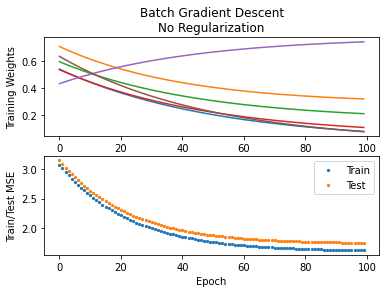

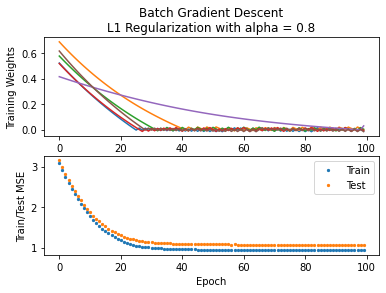

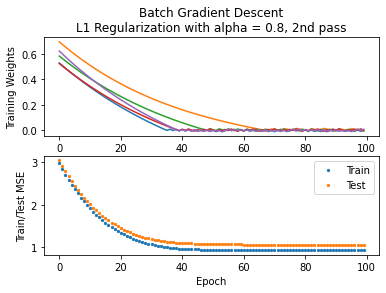

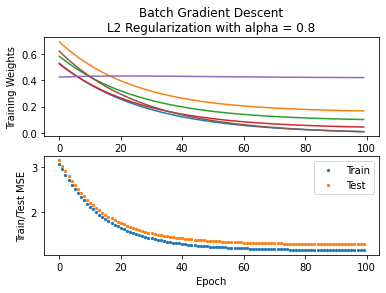

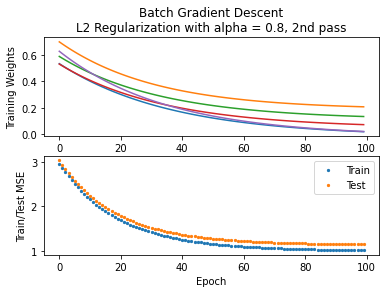

In [ ]:
def batchGD(x_train,x_test,y_train,y_test,max_epoch,min_mse,learn_rate,regs,w):
  #Store w, error for each training epoch
  allW = np.zeros((len(w), 0))
  allTrain = np.zeros((1, 0))
  allTest = np.zeros((1, 0))
  prev_best_idx = 0;
  prev_best_trmse = 1e15;
  prev_best_temse = 1e15;

  if (regs == Reg.NO):
    alpha = 0
  else:
    # Use Cross validation to obtain alpha
    alpha = CrossValidation(x_train, x_test, y_train, y_test, w, regs, learn_rate)

  for i in range(0, max_epoch):

    # Call our gradientDescent function
    w, train_mse, test_mse = gradientDescent(x_train, x_test, y_train, y_test, w, regs, learn_rate, alpha)

    allW = np.append(allW, np.array(w), axis=1)
    allTrain = np.append(allTrain, train_mse)
    allTest = np.append(allTest, test_mse)

    if (train_mse < prev_best_trmse and test_mse < prev_best_temse):
      prev_best_idx = i
      prev_best_trmse = train_mse
      prev_best_temse = test_mse

    #Check for error break condition
    if (train_mse <= min_mse):
      break

  return allW, allTrain, allTest, prev_best_idx, alpha

########### PARAMETERS #############
max_epoch = 100    #Number of iterations
min_mse = 0.001    #Termination error value
learn_rate = 0.01  #Learning rate for the algorithm

Title1 = "Batch Gradient Descent\n"
Title2 = ["No Regularization", "L1 Regularization", "L2 Regularization"]

for regs in Reg:
  #Set up the weight vector (w), of dimension n+1, where n is number of attributes
  # Randomly initialize w, this was in for loop before, randoming every time lol
  np.random.seed(0)
  w = np.random.rand(len(x_train[0]),1)

  #Store local X for modification with regularization
  loc_x_train = x_train
  loc_x_test = x_test

  allW,allTrain,allTest,idx,alpha = batchGD(x_train, x_test, y_train, y_test, max_epoch, min_mse, learn_rate, regs, w)
  Title2 = ["No Regularization", "L1 Regularization with alpha = " + str(alpha), "L2 Regularization with alpha = " + str(alpha)]
  PlotWeightsAndErrors(allW,allTrain,allTest,Title1+Title2[regs])

  if (regs == Reg.NO):
    continue
  elif (len(w) > 1):
    min_index = np.argmin(w)
    loc_x_train = np.delete(x_train, min_index,1)
    loc_x_test = np.delete(x_test, min_index,1)
    w = np.delete(w, min_index)
    w = w[:, None]

  allW, allTrain,allTest,idx,alpha = batchGD(loc_x_train, loc_x_test, y_train, y_test, max_epoch, min_mse, learn_rate, regs, w)
  PlotWeightsAndErrors(allW,allTrain,allTest,Title1+Title2[regs]+", 2nd pass")



# 5. Stochastic Gradient Descent Results

* **Stochastic**: without L2 regularization, with L2 regularization, with L1 regularization



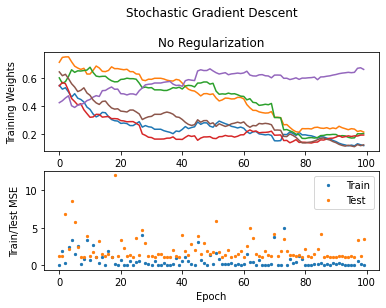

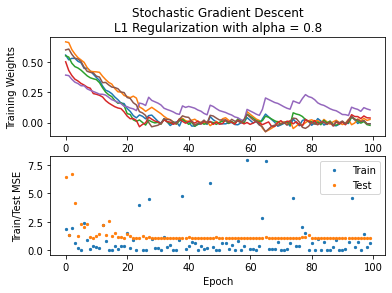

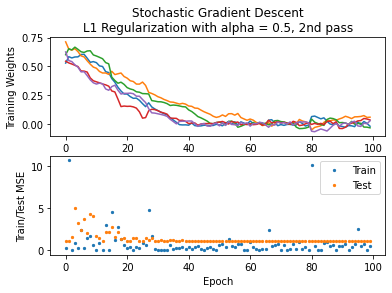

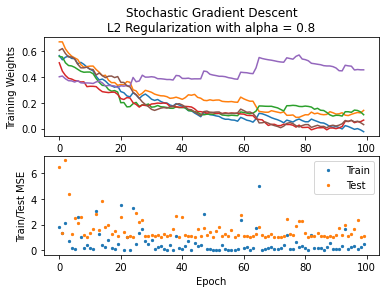

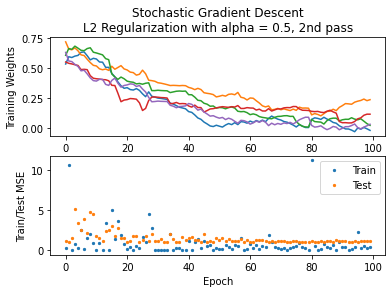

In [ ]:
def stochasticGD(x_train,x_test,y_train,y_test,max_epoch,min_mse,learn_rate,regs,w):
  #Store w, error for each training epoch
  allW = np.zeros((len(w), 0))
  allTrain = np.zeros((1, 0))
  allTest = np.zeros((1, 0))
  prev_best_idx = 0;
  prev_best_trmse = 1e15;
  prev_best_temse = 1e15;

  #Store local X for modification with regularization
  loc_x_train = x_train
  loc_x_test = x_test
  loc_y_train = y_train
  loc_y_test = y_test

  if (regs == Reg.NO):
    alpha = 0
  else:
    # Use Cross validation to obtain alpha
    alpha = CrossValidation(x_train, x_test, y_train, y_test, w, regs, learn_rate)

  for i in range(0, max_epoch):

    # Pick a random point to use for GD
    ridx = np.random.randint(len(loc_y_train)-1)
    xtr = np.array([loc_x_train[ridx]])
    ytr = np.array([loc_y_train[ridx,0]])

    # Call our gradientDescent function
    w, train_mse, test_mse = gradientDescent(xtr, loc_x_test, ytr, loc_y_test, w, regs, learn_rate, alpha)

    # print(i), print(w), print(train_mse)
    allW = np.append(allW, w, axis=1)
    allTrain = np.append(allTrain, train_mse)
    allTest = np.append(allTest, test_mse)

    if (train_mse < prev_best_trmse and test_mse < prev_best_temse):
      prev_best_idx = i
      prev_best_trmse = train_mse
      prev_best_temse = test_mse

    #Check for error break condition
    if (train_mse <= min_mse and test_mse <= min_mse):
      break

  return allW, allTrain, allTest, prev_best_idx, alpha

########### PARAMETERS #############
max_epoch = 100  #Number of iterations
min_mse = 0.0001    #Termination error value
learn_rate = 0.01  #Learning rate for the algorithm

Title1 = "Stochastic Gradient Descent\n"

for regs in Reg:
  #Set up the weight vector (w), of dimension n+1, where n is number of attributes
  # Randomly initialize w, this was in for loop before, randoming every time lol
  np.random.seed(0)
  w = np.random.rand(len(x_train[0]),1)

  allW,allTrain,allTest,idx,alpha = stochasticGD(x_train, x_test, y_train, y_test, max_epoch, min_mse, learn_rate, regs, w)
  
  Title2 = ["\nNo Regularization", "L1 Regularization with alpha = " + str(alpha), "L2 Regularization with alpha = " + str(alpha)]
  PlotWeightsAndErrors(allW,allTrain,allTest,Title1+Title2[regs])

  if (regs == Reg.NO):
    continue
  elif (len(w) > 1):
    min_index = np.argmin(w)
    loc_x_train = np.delete(x_train, min_index,1)
    loc_x_test = np.delete(x_test, min_index,1)
    w = np.delete(w, min_index)
    w = w[:, None]

  allW, allTrain,allTest,idx,alpha = stochasticGD(loc_x_train, loc_x_test, y_train, y_test, max_epoch, min_mse, learn_rate, regs, w)
  Title2 = ["No Regularization", "L1 Regularization with alpha = " + str(alpha), "L2 Regularization with alpha = " + str(alpha)]
  PlotWeightsAndErrors(allW,allTrain,allTest,Title1+Title2[regs]+", 2nd pass")



# 6. Mini Batch Gradient Descent Results

* **Mini Batch**: without L2 regularization, with L2 regularization, with L1 regularization



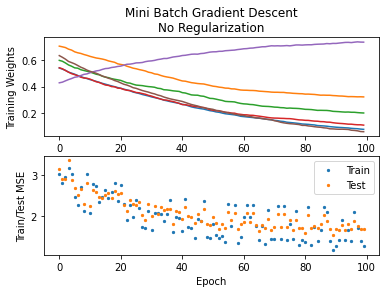

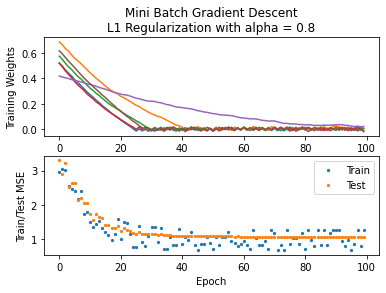

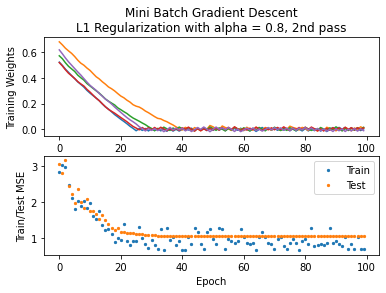

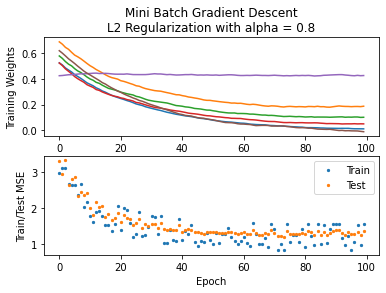

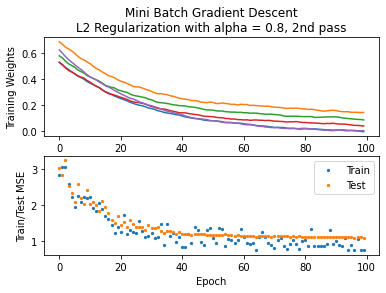

In [ ]:
def miniBatchGD(x_train,x_test,y_train,y_test,max_epoch,min_mse,learn_rate,regs,w,batch_size):
  #Store w, error for each training epoch
  allW = np.zeros((len(w), 0))
  allTrain = np.zeros((1, 0))
  allTest = np.zeros((1, 0))
  prev_best_idx = 0;
  prev_best_trmse = 1e15;
  prev_best_temse = 1e15;

  if (regs == Reg.NO):
      alpha = 0
  else:
      # Use Cross validation to obtain alpha
      alpha = CrossValidation(x_train, x_test, y_train, y_test, w, regs, learn_rate)
      
  for i in range(0, max_epoch):
    #Randomly pick values from x_train to evaluate against
    n_batches = int(len(loc_x_train)/batch_size)    
    multi_index = int(np.random.rand(1)*n_batches)*batch_size  #Select a random batch for every iteration.
    multi_x_train = x_train[multi_index : multi_index + batch_size]
    multi_y_train = y_train[multi_index : multi_index + batch_size]
  
   # Call our gradientDescent function
    w, train_mse, test_mse = gradientDescent(multi_x_train, x_test, multi_y_train, y_test, w, regs, learn_rate, alpha)

    allW = np.append(allW, np.array(w), axis=1)
    allTrain = np.append(allTrain, train_mse)
    allTest = np.append(allTest, test_mse)

    if (train_mse < prev_best_trmse and test_mse < prev_best_temse):
      prev_best_idx = i
      prev_best_trmse = train_mse
      prev_best_temse = test_mse

    #Check for error break condition
    if (train_mse <= min_mse or len(multi_x_train) < batch_size):
      break

  return allW, allTrain, allTest, prev_best_idx, alpha


## PARAMETERS ##
max_epoch = 100  #Number of iterations
min_mse = 0.01    #Termination error value
learn_rate = 0.01  #Learning rate for the algorithm
batch_size = 50

Title1 = "Mini Batch Gradient Descent\n"


for regs in Reg:
  #Set up the weight vector (w), of dimension n+1, where n is number of attributes
  # Randomly initialize w, this was in for loop before, randoming every time lol
  np.random.seed(0)
  w = np.random.rand(len(x_train[0]),1)

  allW,allTrain,allTest,idx, alpha = miniBatchGD(x_train, x_test, y_train, y_test, max_epoch, min_mse, learn_rate, regs, w, batch_size)
  Title2 = ["No Regularization", "L1 Regularization with alpha = " + str(alpha), "L2 Regularization with alpha = " + str(alpha)]
  PlotWeightsAndErrors(allW,allTrain,allTest,Title1+Title2[regs])

  if (regs == Reg.NO):
    continue
  elif (len(w) > 1):
    min_index = np.argmin(w)
    loc_x_train = np.delete(x_train, min_index,1)
    loc_x_test = np.delete(x_test, min_index,1)
    w = np.delete(w, min_index)
    w = w[:, None]

  allW, allTrain,allTest,idx, alpha = miniBatchGD(loc_x_train, loc_x_test, y_train, y_test, max_epoch, min_mse, learn_rate, regs, w, batch_size)
  PlotWeightsAndErrors(allW,allTrain,allTest,Title1+Title2[regs]+", 2nd pass")